In [1]:
#Read ATL11 timeseries into geodataframe(s) of single RGT from cloud with earthaccess

In [28]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import earthaccess
import IS2view
#import icepyx as ipx
import geopandas as gpd
from shapely import Point
import pandas as pd
%matplotlib inline

In [29]:
auth = earthaccess.login()
# attempt to use cloud streaming if in us-west-2
try:
    provider = "NSIDC_CPRD"
    asset = "nsidc-s3"
    fs = earthaccess.get_s3fs_session(provider=provider)
except (AttributeError, NameError) as exc:
    provider = "NSIDC_ECS"
    asset = "nsidc-https"
# parameters for ATL11 Release-05 granule
product = "ATL11"
release = "006"
RGT = 230#79#582#201
granule = 3
# build a readable granule pattern for ATL11
pattern = f"{product}_{RGT:04d}{granule:02d}_*"
# query CMR for path to ATL11 Release-05 granule
results = earthaccess.search_data(
    short_name = product,
    version = release,
    granule_name = pattern,
#    provider = provider,
    cloud_hosted = True,
    bounding_box = (-23.565674,76.693278,-21.884766,77.148205), #from bboxfinder.com
)
# display results
results
print(len(results))

# access or download ATL11 file from NSIDC
if (asset == 'nsidc-s3'):
    fileset = earthaccess.open(results)
elif (asset == 'nsidc-https'):
    fileset = earthaccess.download(results, local_path='.')

1


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
#Create Geodataframes for each cycle from ATL11 timeseries

In [31]:
ds = h5py.File(fileset[0], 'r')
ds['pt2']['ref_surf'].keys()
ds['pt2']['ref_surf']['geoid_h']

<HDF5 dataset "geoid_h": shape (19488,), type "<f4">

In [32]:
# Initialize an empty dictionary to store non-empty GeoDataFrames
# Load the HDF5 file
ds = h5py.File(fileset[0], 'r')

pt = 'pt2' #Set beam pair
cycle = np.array(ds[pt]['cycle_number'])#[16:23]
smoothing_window = 10

gdf_dict = {}

# Loop through all unique cycle numbers
# Loop through all unique cycle numbers
for cyclenumber in np.unique(cycle):
    # Find indices corresponding to the current cycle number
    cycle_indices = np.where(cycle == cyclenumber)[0]

    geoid = np.array(ds[pt]['ref_surf']['geoid_h']).squeeze()
    # Extract relevant data for the current cycle number
    h_corr = np.array(ds[pt]['h_corr'][:, cycle_indices])
    h_corr_all = np.array(ds[pt]['h_corr'])
    h_corr_sigma = np.array(ds[pt]['h_corr_sigma'][:, cycle_indices])
    lat = np.array(ds[pt]['latitude'])
    lon = np.array(ds[pt]['longitude'])
    qa = np.array(ds[pt]['quality_summary'])#[:, cycle_indices])
    qa_cycle = np.array(ds[pt]['quality_summary'][:, cycle_indices])
    
    
    
    ## MASKING ##
    # Create a mask where qa is not equal to 1
    mask = (qa != 0)
    mask_cycle = (qa_cycle != 0)

    
    # Apply the mask: Set values to np.nan in h_corr_all where qa != 0
    h_corr_all_masked = np.where(mask, np.nan, h_corr_all)

    # Apply the mask: Set values to np.nan in h_corr_all where qa != 0
    h_corr_masked = np.where(mask_cycle, np.nan, h_corr)

    # Apply the mask: Set values to np.nan in h_corr_all where qa != 0
    geoid_masked = np.where(mask_cycle, np.nan, geoid)    
    ## SMOOTHING ##
    
    def moving_average_ignore_nan(array, window_size):
    # Convert the array into a pandas DataFrame to use rolling
        df = pd.DataFrame(array)
    
    # Apply a rolling window and calculate the mean, ignoring NaNs
        smoothed_array = df.rolling(window=window_size, min_periods=1, axis=1).mean().values
    
        return smoothed_array

    # Apply the custom moving average function
    h_corr_all_smoothed = moving_average_ignore_nan(h_corr_all_masked, window_size=smoothing_window)

    df = pd.DataFrame(h_corr_masked)
    h_corr_smoothed = df.rolling(window=1, min_periods=1).mean().values
    # Calculate the nanmean across the 21 time steps (axis=1)
    h_mean = np.nanmean(h_corr_all_masked, axis=1)
    h_mean_smoothed = np.nanmean(h_corr_all_smoothed, axis=1)

    h_anomaly = h_corr_smoothed.squeeze() - h_mean_smoothed

    
    # Compute variance while ignoring NaN values
    h_variance = np.nanvar(h_corr_all_smoothed, axis=1)
    
    # Create the GeoDataFrame
    gdf = gpd.GeoDataFrame({
        'h_corr': h_corr_masked.squeeze() - geoid.squeeze(),#).flatten(),
        'h_corr_smoothed': h_corr_smoothed.squeeze() - geoid.squeeze(),
        'h_corr_sigma': h_corr_sigma.squeeze(),
        'h_var' : h_variance.squeeze(),
        #'h_var_smoothed' : h_variance_smoothed.squeeze(),
        'latitude': lat,
        'longitude': lon,
        'qa_cycle': qa_cycle.squeeze(),
        'h_mean' : h_mean.squeeze(),
        'h_mean_smoothed' : h_mean_smoothed.squeeze(),
        'h_anomaly' : h_anomaly.squeeze(),
        'geometry': [Point(xy) for xy in zip(lon, lat)]
    })
    
    # Set the coordinate reference system (CRS)
    gdf.set_crs(epsg=4326, inplace=True)
    
    # Check if the gdf is not empty
    if not gdf.empty:
        # Store the gdf in the dictionary with the cycle number as the key
        gdf_dict[cyclenumber] = gdf

# List all cycle numbers with non-empty gdfs
non_empty_cycles = list(gdf_dict.keys())
print("Cycle numbers with non-empty GeoDataFrames:")
print(non_empty_cycles)


/tmp/ipykernel_194/2356559352.py:50: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  smoothed_array = df.rolling(window=window_size, min_periods=1, axis=1).mean().values
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_194/2356559352.py:50: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  smoothed_array = df.rolling(window=window_size, min_periods=1, axis=1).mean().values
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_194/2356559352.py:50: FutureWarning: Support for axis=1 in DataFrame.rollin

Cycle numbers with non-empty GeoDataFrames:
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [33]:
gdf.head(50)

,h_corr,h_corr_smoothed,h_corr_sigma,h_var,latitude,longitude,qa_cycle,h_mean,h_mean_smoothed,h_anomaly,geometry
0,NaN,NaN,3.402823e+38,0.069921,63.425846,-17.092550,1,64.046455,64.127904,NaN,POINT (-17.09255 63.42585)
1,NaN,NaN,3.402823e+38,0.047876,63.426382,-17.092678,1,63.970119,64.009367,NaN,POINT (-17.09268 63.42638)
2,NaN,NaN,3.402823e+38,0.004718,63.426917,-17.092827,1,64.121620,64.102205,NaN,POINT (-17.09283 63.42692)
3,NaN,NaN,3.402823e+38,0.016193,63.427453,-17.092956,1,64.159615,64.151625,NaN,POINT (-17.09296 63.42745)
4,NaN,NaN,3.402823e+38,0.048582,63.427988,-17.093084,1,64.008675,63.938451,NaN,POINT (-17.09308 63.42799)
5,NaN,NaN,3.402823e+38,0.019502,63.428524,-17.093213,1,64.215942,64.226595,NaN,POINT (-17.09321 63.42852)
6,NaN,NaN,3.402823e+38,0.019983,63.429060,-17.093342,1,64.282387,64.320309,NaN,POINT (-17.09334 63.42906)
7,NaN,NaN,3.402823e+38,0.012125,63.429596,-17.093460,1,64.321419,64.340366,NaN,POINT (-17.09346 63.4296)
8,NaN,NaN,3.402823e+38,0.061358,63.430131,-17.093599,1,64.270576,64.324856,NaN,POINT (-17.0936 63.43013)
9,NaN,NaN,3.402823e+38,0.051713,63.430667,-17.093728,1,64.243164,64.294235,NaN,POINT (-17.09373 63.43067)


/tmp/ipykernel_194/3220834237.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab10', len(gdf_dict))


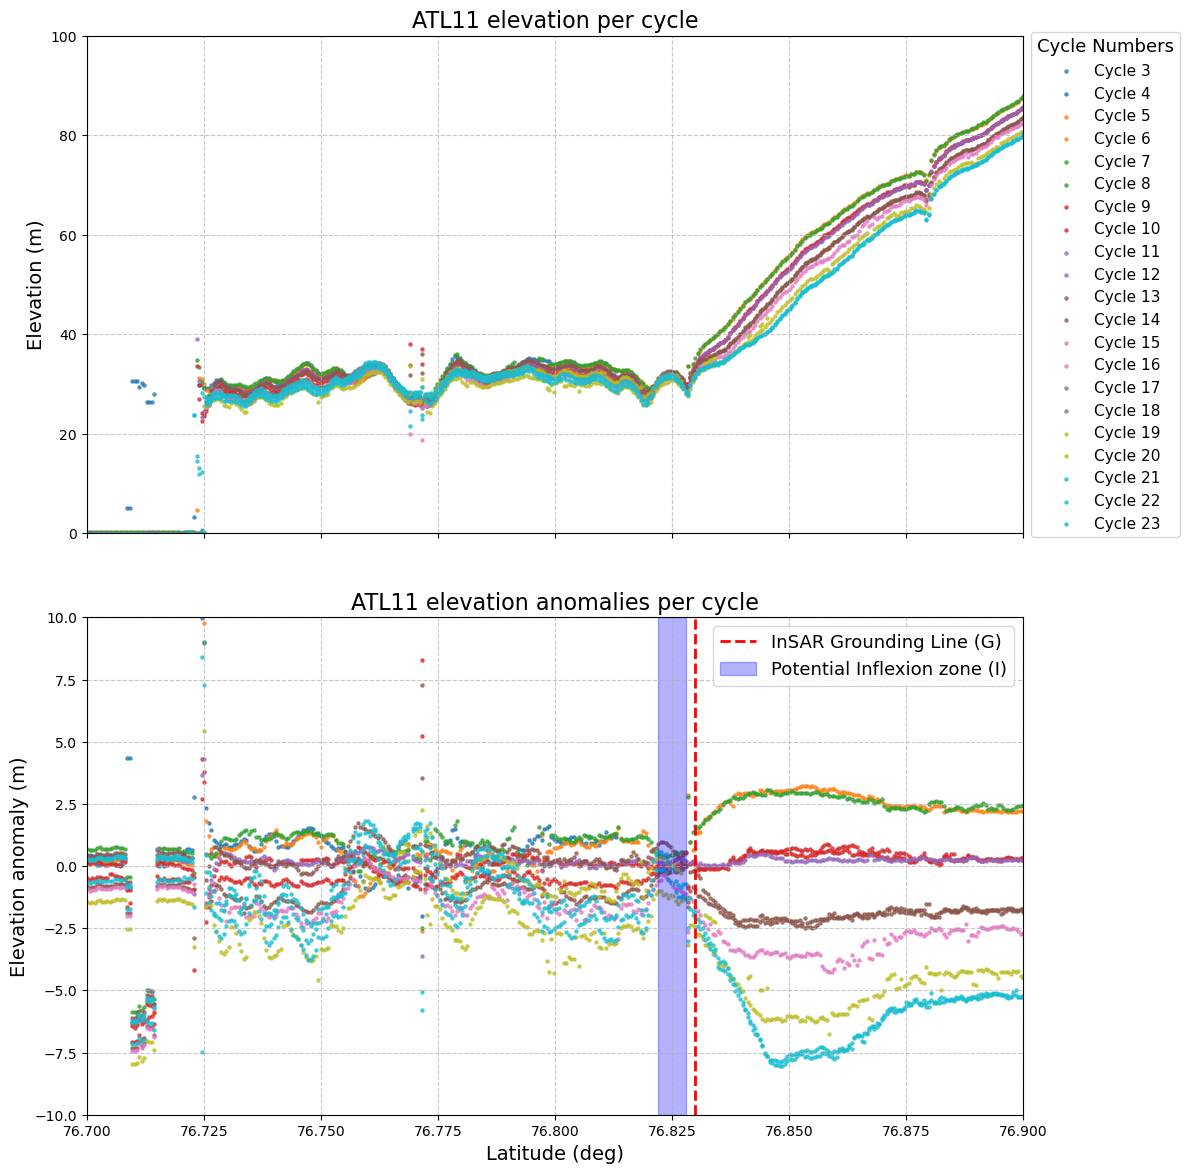

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Define a colormap to get different colors
colormap = plt.cm.get_cmap('tab10', len(gdf_dict))

# First subplot: Scatter Plot of Latitude vs. h_corr_smoothed
for idx, (cyclenumber, gdf) in enumerate(gdf_dict.items()):
    ax1.scatter(gdf['latitude'], gdf['h_corr_smoothed'], 
                color=colormap(idx),  # Use a different color for each cycle
                s=5,  # Increase marker size for better visibility
                alpha=0.7,  # Add transparency to make overlapping points more visible
                label=f'Cycle {cyclenumber}')

ax1.set_title('ATL11 elevation per cycle', fontsize=16)
ax1.set_ylabel('Elevation (m)', fontsize=14)
ax1.set_ylim(0, 100)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(title='Cycle Numbers', title_fontsize='13', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))

# Second subplot: Along-track Height Anomaly per Cycle
for idx, (cyclenumber, gdf) in enumerate(gdf_dict.items()):
    ax2.scatter(gdf['latitude'], gdf['h_anomaly'], 
                color=colormap(idx),  # Use a different color for each cycle
                s=5,  # Increase marker size for better visibility
                alpha=0.7)  # Add transparency to make overlapping points more visible
                #label=f'Cycle {cyclenumber}')

ax2.axvline(x=76.83, color='red', linestyle='--', linewidth=2, label='InSAR Grounding Line (G)')
#ax2.axvline(x=76.825, color='blue', linestyle='--', linewidth=2, label='Potential inflexion zone (I)')
ax2.axvspan(xmin=76.822, xmax=76.828, color='blue', alpha=0.3, label='Potential Inflexion zone (I)')

ax2.set_title('ATL11 elevation anomalies per cycle', fontsize=16)
ax2.set_xlabel('Latitude (deg)', fontsize=14)
ax2.set_ylabel('Elevation anomaly (m)', fontsize=14)
ax2.set_ylim(-10, 10)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(fontsize='13')#, loc='left')#, bbox_to_anchor=(1, 0.5))

# Set the x-axis limits for both plots
ax1.set_xlim(76.7, 76.9)

# Improve the layout to ensure everything fits nicely
plt.tight_layout()

# Show the plot
plt.show()


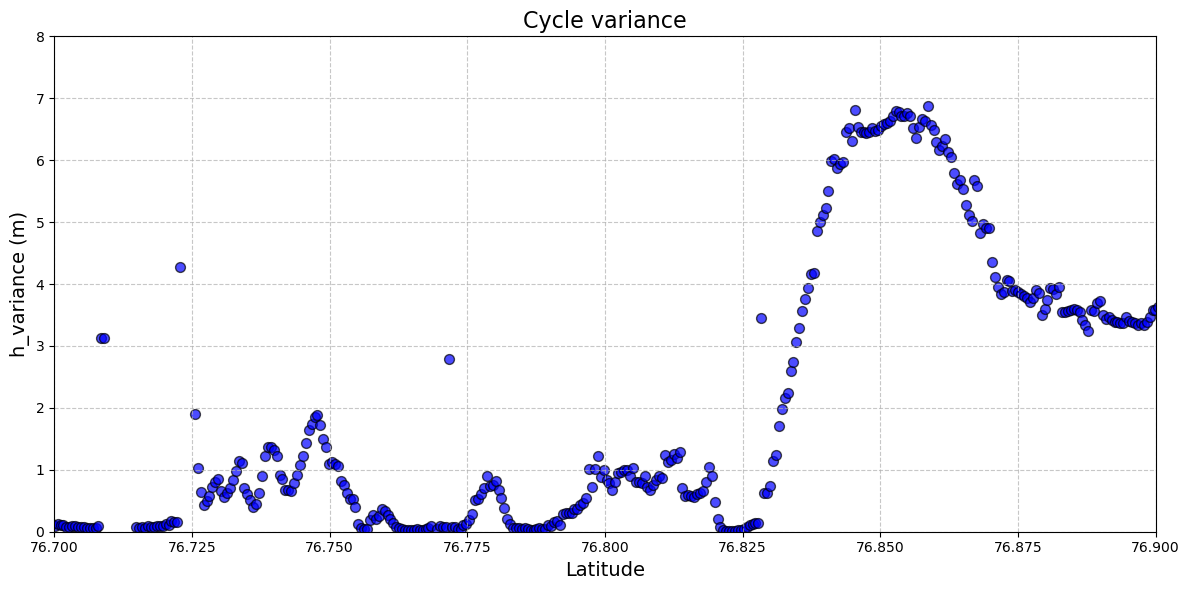

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot with a larger figure size
plt.figure(figsize=(12, 6))

# Extract the specific GeoDataFrame for cycle 3
gdf = gdf_dict[3]

# Plot the data using a scatter plot
plt.scatter(gdf['latitude'], gdf['h_var'], 
            color='blue', 
            s=50,  # Increase marker size for better visibility
            edgecolor='black',  # Add black edge color to markers
            alpha=0.7,  # Add transparency to make overlapping points more visible
            label='Cycle 3')

# Add a vertical line to indicate the Grounding Line (GL)
#plt.axvline(x=76.83, color='red', linestyle='--', linewidth=2, label='GL')

# Add plot details
plt.title('Cycle variance', fontsize=16)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('h_variance (m)', fontsize=14)
plt.ylim(0, 8)
plt.xlim(76.7, 76.9)
plt.grid(True, linestyle='--', alpha=0.7)

# Display the legend on the right side
#plt.legend(title='Legend', title_fontsize='13', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))

# Improve the layout to ensure everything fits nicely
plt.tight_layout()

# Show the plot
plt.show()
